In [ ]:
# ============================================
# IMPORTS
# ============================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from datetime import datetime
from collections import Counter
import warnings
import random
warnings.filterwarnings('ignore')

# ============================================
# REPRODUCIBILITY
# ============================================
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================
# DEVICE SETUP
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", device)

# ============================================
# LOAD & CLEAN DATA WITH FEATURE ENGINEERING
# ============================================
print("\n" + "="*80)
print("LOADING & PREPROCESSING DATA")
print("="*80)

train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

columns = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

df_train = pd.read_csv(train_url, header=None, names=columns, skipinitialspace=True)
df_test = pd.read_csv(test_url, header=0, names=columns, skiprows=1, skipinitialspace=True)

df_train["income"] = df_train["income"].str.replace(".", "", regex=False).str.strip()
df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()

df_train.replace("?", pd.NA, inplace=True)
df_test.replace("?", pd.NA, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

# Feature Engineering
df['age_squared'] = df['age'] ** 2
df['hours_per_week_squared'] = df['hours-per-week'] ** 2
df['capital_total'] = df['capital-gain'] - df['capital-loss']
df['education_hours_interaction'] = df['education-num'] * df['hours-per-week']

df_encoded = df.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == "object":
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded.drop(columns=["income"]).values.astype(float)
y = df_encoded["income"].values.astype(int)

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"Train set size: {len(X_train)} | Test set size: {len(X_test)}")
print(f"Class distribution - Train: {Counter(y_train)}")
print(f"Class imbalance ratio: {Counter(y_train)[0]/Counter(y_train)[1]:.2f}:1")

# ============================================
# FEATURE WEIGHTS FOR MASKING
# ============================================
D = X_train.shape[1]
feature_weights = np.linspace(0.1, 1.0, D)
feature_weights = feature_weights / feature_weights.max()

# ============================================
# ADVANCED MIXED MASKING FUNCTION
# ============================================
def advanced_mixed_masking(
    X,
    weights=None,
    mask_rate=0.40,
    use_cutout=True,
    use_mixup=True
):
    """
    ترکیب چندین استراتژی masking پیشرفته
    """
    X_masked = X.copy()
    n_samples, n_features = X.shape

    if weights is None:
        weights = np.ones(n_features)

    # محاسبه اهمیت features
    feature_var = np.var(X, axis=0) + 1e-12
    feature_importance = feature_var / feature_var.sum()

    for i in range(n_samples):
        strategy = np.random.choice(
            ['weighted', 'random', 'block', 'cutout', 'mixup'],
            p=[0.35, 0.20, 0.20, 0.15, 0.10]
        )

        if strategy == 'weighted':
            n_mask = max(1, int(n_features * mask_rate))
            mask_idx = np.random.choice(
                n_features, size=n_mask, replace=False, p=feature_importance
            )
            X_masked[i, mask_idx] = 0.0

        elif strategy == 'random':
            mask = np.random.rand(n_features) < mask_rate
            X_masked[i, mask] = 0.0

        elif strategy == 'block':
            block_size = np.random.randint(3, max(4, n_features // 5))
            start = np.random.randint(0, max(1, n_features - block_size))
            X_masked[i, start:start + block_size] = 0.0

        elif strategy == 'cutout' and use_cutout:
            n_cutout = max(1, int(n_features * 0.2))
            cutout_idx = np.random.choice(n_features, size=n_cutout, replace=False)
            X_masked[i, cutout_idx] = np.mean(X[:, cutout_idx], axis=0)

        elif strategy == 'mixup' and use_mixup and i < n_samples - 1:
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            other_idx = np.random.randint(0, n_samples)
            n_mix = max(1, int(n_features * 0.3))
            mix_idx = np.random.choice(n_features, size=n_mix, replace=False)
            X_masked[i, mix_idx] = (
                lam * X[i, mix_idx] + (1 - lam) * X[other_idx, mix_idx]
            )

        # افزودن نویز گاوسی
        if np.random.rand() < 0.15:
            noise_idx = np.random.choice(
                n_features, size=max(1, int(n_features * 0.1)), replace=False
            )
            X_masked[i, noise_idx] += np.random.normal(0, 0.05, size=len(noise_idx))

    return X_masked

# ============================================
# IMPROVED SSL RECONSTRUCTION NETWORK
# ============================================
class ImprovedReconstructionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim

        # Encoder with residual connections
        self.enc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.enc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.enc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        # Decoder
        self.dec1 = nn.Linear(128, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dec2 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dec3 = nn.Linear(512, input_dim)

        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        # Encoder
        e1 = self.activation(self.bn1(self.enc1(x)))
        e1 = self.dropout(e1)
        e2 = self.activation(self.bn2(self.enc2(e1)))
        e2 = self.dropout(e2)
        latent = self.activation(self.bn3(self.enc3(e2)))

        # Decoder
        d1 = self.activation(self.bn4(self.dec1(latent)))
        d1 = self.dropout(d1)
        d2 = self.activation(self.bn5(self.dec2(d1)))
        d2 = self.dropout(d2)
        recon = self.dec3(d2)

        return recon, latent

# ============================================
# COMBINED LOSS FUNCTIONS
# ============================================
class CombinedReconstructionLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.cosine = nn.CosineSimilarity(dim=1)

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        cosine_loss = 1 - self.cosine(pred, target).mean()
        return 0.7 * mse_loss + 0.3 * cosine_loss

class FocalDiceLoss(nn.Module):
    """ترکیب Focal Loss و Dice Loss"""
    def __init__(self, alpha=0.25, gamma=2.0, dice_smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.dice_smooth = dice_smooth

    def forward(self, logits, targets):
        # Focal Loss
        probs = torch.sigmoid(logits)
        targets_f = targets.float()

        focal_weight = torch.where(
            targets == 1,
            self.alpha * (1 - probs) ** self.gamma,
            (1 - self.alpha) * probs ** self.gamma
        )
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, targets_f, reduction='none'
        )
        focal_loss = (focal_weight * bce).mean()

        # Dice Loss
        intersection = (probs * targets_f).sum()
        union = probs.sum() + targets_f.sum()
        dice_loss = 1 - (2 * intersection + self.dice_smooth) / (union + self.dice_smooth)

        return 0.6 * focal_loss + 0.4 * dice_loss

# ============================================
# TOP 20 CONFIGURATIONS
# ============================================
top_20_configs = [
    {"n_d": 48, "n_a": 48, "n_steps": 3, "gamma": 1.8, "lambda_sparse": 0.0005, "lr": 0.020, "cat_emb_dim": 5, "batch_size": 1024},
    {"n_d": 32, "n_a": 48, "n_steps": 3, "gamma": 1.5, "lambda_sparse": 0.0010, "lr": 0.020, "cat_emb_dim": 4, "batch_size": 1024},
    {"n_d": 16, "n_a": 64, "n_steps": 4, "gamma": 1.3, "lambda_sparse": 0.0010, "lr": 0.015, "cat_emb_dim": 2, "batch_size": 1024},
    {"n_d": 32, "n_a": 16, "n_steps": 7, "gamma": 1.0, "lambda_sparse": 0.0000, "lr": 0.020, "cat_emb_dim": 2, "batch_size": 256},
    {"n_d": 64, "n_a": 64, "n_steps": 7, "gamma": 1.3, "lambda_sparse": 0.0000, "lr": 0.010, "cat_emb_dim": 3, "batch_size": 1024},
    {"n_d": 48, "n_a": 16, "n_steps": 3, "gamma": 1.3, "lambda_sparse": 0.0000, "lr": 0.015, "cat_emb_dim": 3, "batch_size": 256},
    {"n_d": 16, "n_a": 48, "n_steps": 4, "gamma": 1.0, "lambda_sparse": 0.0100, "lr": 0.020, "cat_emb_dim": 3, "batch_size": 1024},
    {"n_d": 48, "n_a": 32, "n_steps": 5, "gamma": 1.5, "lambda_sparse": 0.0000, "lr": 0.005, "cat_emb_dim": 4, "batch_size": 512},
    {"n_d": 16, "n_a": 48, "n_steps": 6, "gamma": 1.0, "lambda_sparse": 0.0001, "lr": 0.020, "cat_emb_dim": 4, "batch_size": 512},
    {"n_d": 48, "n_a": 32, "n_steps": 4, "gamma": 1.2, "lambda_sparse": 0.0005, "lr": 0.015, "cat_emb_dim": 3, "batch_size": 1024},
    {"n_d": 32, "n_a": 32, "n_steps": 6, "gamma": 1.0, "lambda_sparse": 0.0000, "lr": 0.025, "cat_emb_dim": 4, "batch_size": 1024},
    {"n_d": 48, "n_a": 16, "n_steps": 3, "gamma": 1.8, "lambda_sparse": 0.0001, "lr": 0.015, "cat_emb_dim": 2, "batch_size": 1024},
    {"n_d": 64, "n_a": 64, "n_steps": 6, "gamma": 1.3, "lambda_sparse": 0.0010, "lr": 0.015, "cat_emb_dim": 4, "batch_size": 1024},
    {"n_d": 32, "n_a": 16, "n_steps": 5, "gamma": 1.3, "lambda_sparse": 0.0001, "lr": 0.025, "cat_emb_dim": 2, "batch_size": 512},
    {"n_d": 32, "n_a": 16, "n_steps": 3, "gamma": 1.2, "lambda_sparse": 0.0001, "lr": 0.020, "cat_emb_dim": 4, "batch_size": 1024},
    {"n_d": 16, "n_a": 16, "n_steps": 3, "gamma": 1.3, "lambda_sparse": 0.0010, "lr": 0.015, "cat_emb_dim": 2, "batch_size": 512},
    {"n_d": 32, "n_a": 32, "n_steps": 3, "gamma": 1.0, "lambda_sparse": 0.0001, "lr": 0.010, "cat_emb_dim": 2, "batch_size": 256},
    {"n_d": 64, "n_a": 48, "n_steps": 4, "gamma": 1.3, "lambda_sparse": 0.0000, "lr": 0.005, "cat_emb_dim": 2, "batch_size": 1024},
    {"n_d": 32, "n_a": 16, "n_steps": 5, "gamma": 1.3, "lambda_sparse": 0.0001, "lr": 0.005, "cat_emb_dim": 1, "batch_size": 1024},
    {"n_d": 32, "n_a": 16, "n_steps": 3, "gamma": 1.0, "lambda_sparse": 0.0005, "lr": 0.010, "cat_emb_dim": 4, "batch_size": 1024},
]

# ============================================
# PHASE 1: QUICK CONFIGURATION SELECTION
# ============================================
print("\n" + "="*80)
print("PHASE 1: QUICK CONFIGURATION SELECTION (20 Configs)")
print("="*80)

def quick_evaluate_config(config, X_train, y_train, X_test, y_test, config_idx):
    """ارزیابی سریع هر configuration"""
    try:
        # Set seed
        np.random.seed(SEED + config_idx)
        torch.manual_seed(SEED + config_idx)

        # Quick masking
        X_train_masked = advanced_mixed_masking(X_train, weights=feature_weights, mask_rate=0.35)

        # Quick TabNet pretraining
        pretrainer = TabNetPretrainer(
            n_d=config['n_d'],
            n_a=config['n_a'],
            n_steps=config['n_steps'],
            gamma=config['gamma'],
            lambda_sparse=config['lambda_sparse'],
            mask_type='entmax',
            optimizer_params=dict(lr=config['lr']),
            verbose=0
        )

        pretrainer.fit(
            X_train=X_train_masked,
            eval_set=[X_test],
            max_epochs=30,  # کاهش epochs برای سرعت
            patience=10,
            batch_size=config['batch_size'],
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )

        # Quick classification
        clf = TabNetClassifier(
            n_d=config['n_d'],
            n_a=config['n_a'],
            n_steps=config['n_steps'],
            gamma=config['gamma'],
            lambda_sparse=config['lambda_sparse'],
            cat_emb_dim=config['cat_emb_dim'],
            optimizer_params=dict(lr=config['lr']),
            mask_type='sparsemax',
            verbose=0
        )

        clf.fit(
            X_train=X_train,
            y_train=y_train,
            eval_set=[(X_test, y_test)],
            max_epochs=20,  # کاهش epochs
            patience=10,
            batch_size=config['batch_size'],
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            from_unsupervised=pretrainer
        )

        # Evaluate
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        print(f"Config {config_idx+1:2d}/20 | F1: {f1:.4f} | Acc: {acc:.4f}")

        return {
            'config_idx': config_idx,
            'config': config,
            'f1': f1,
            'acc': acc
        }

    except Exception as e:
        print(f"Config {config_idx+1:2d}/20 | FAILED: {str(e)}")
        return {
            'config_idx': config_idx,
            'config': config,
            'f1': 0.0,
            'acc': 0.0
        }
    finally:
        torch.cuda.empty_cache()

# Run quick evaluation on all configs
quick_results = []
for idx, config in enumerate(top_20_configs):
    result = quick_evaluate_config(config, X_train, y_train, X_test, y_test, idx)
    quick_results.append(result)

# Find best configuration
quick_results_sorted = sorted(quick_results, key=lambda x: x['f1'], reverse=True)
best_config = quick_results_sorted[0]['config']
best_config_idx = quick_results_sorted[0]['config_idx']

print("\n" + "="*80)
print("BEST CONFIGURATION SELECTED")
print("="*80)
print(f"Config ID: {best_config_idx + 1}")
print(f"Quick F1: {quick_results_sorted[0]['f1']:.4f}")
print(f"Quick Acc: {quick_results_sorted[0]['acc']:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in best_config.items():
    print(f"  {key:15s}: {value}")

# ============================================
# PHASE 2: ADVANCED TRAINING WITH BEST CONFIG
# ============================================
print("\n" + "="*80)
print("PHASE 2: ADVANCED TRAINING WITH BEST CONFIGURATION")
print("="*80)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# Set seed for final training
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ============================================
# STEP 1: SSL RECONSTRUCTION PRETRAINING
# ============================================
print("\n" + "-"*80)
print("STEP 1: SSL RECONSTRUCTION PRETRAINING")
print("-"*80)

ssl_model = ImprovedReconstructionNet(D).to(device)
ssl_optimizer = optim.AdamW(ssl_model.parameters(), lr=2e-3, weight_decay=1e-5)
ssl_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    ssl_optimizer, T_0=10, T_mult=2
)

ssl_criterion = CombinedReconstructionLoss()
ssl_epochs = 80
ssl_batch_size = 256

best_ssl_loss = float('inf')
for epoch in range(ssl_epochs):
    ssl_model.train()
    epoch_loss = 0.0
    batches = 0

    for start in range(0, len(X_train), ssl_batch_size):
        batch = X_train[start:start + ssl_batch_size]
        batch_masked = advanced_mixed_masking(batch, weights=feature_weights, mask_rate=0.40)
        batch_tensor = torch.from_numpy(batch_masked).float().to(device)
        target_tensor = torch.from_numpy(batch).float().to(device)

        ssl_optimizer.zero_grad()
        recon, _ = ssl_model(batch_tensor)
        loss = ssl_criterion(recon, target_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ssl_model.parameters(), max_norm=1.0)
        ssl_optimizer.step()
        ssl_scheduler.step()

        epoch_loss += loss.item()
        batches += 1

    avg_loss = epoch_loss / batches
    if avg_loss < best_ssl_loss:
        best_ssl_loss = avg_loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:02d}/{ssl_epochs} | Loss: {avg_loss:.6f} | Best: {best_ssl_loss:.6f}")

print("SSL Pretraining completed.")

# ============================================
# STEP 2: TABNET UNSUPERVISED PRETRAINING
# ============================================
print("\n" + "-"*80)
print("STEP 2: TABNET UNSUPERVISED PRETRAINING")
print("-"*80)

X_train_masked = advanced_mixed_masking(X_train, weights=feature_weights, mask_rate=0.35)

pretrainer = TabNetPretrainer(
    n_d=best_config["n_d"],
    n_a=best_config["n_a"],
    n_steps=best_config["n_steps"],
    gamma=best_config["gamma"],
    lambda_sparse=best_config["lambda_sparse"],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=best_config["lr"], weight_decay=1e-5),
    mask_type="entmax",
    scheduler_params={"T_0": 10, "T_mult": 2, "eta_min": 1e-5},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    device_name=str(device),
)

pretrainer.fit(
    X_train=X_train_masked,
    eval_set=[X_test],
    max_epochs=150,
    patience=30,
    batch_size=best_config["batch_size"],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

print("TabNet pretraining completed.")

# ============================================
# STEP 3: CLASSIFIER INITIALIZATION
# ============================================
print("\n" + "-"*80)
print("STEP 3: CLASSIFIER INITIALIZATION")
print("-"*80)

clf = TabNetClassifier(
    n_d=best_config["n_d"],
    n_a=best_config["n_a"],
    n_steps=best_config["n_steps"],
    gamma=best_config["gamma"],
    lambda_sparse=best_config["lambda_sparse"],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=best_config["lr"] * 0.5, weight_decay=1e-5),
    scheduler_params={"T_0": 10, "T_mult": 2, "eta_min": 1e-5},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type="sparsemax",
    device_name=str(device),
)

# Warm-up training
clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=["auc"],
    max_epochs=5,
    patience=5,
    batch_size=best_config["batch_size"],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=pretrainer,
)

# ============================================
# STEP 4: ADVANCED FINE-TUNING
# ============================================
print("\n" + "-"*80)
print("STEP 4: ADVANCED FINE-TUNING WITH FOCAL+DICE LOSS")
print("-"*80)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

combined_loss = FocalDiceLoss(alpha=0.25, gamma=2.0).to(device)
optimizer = optim.AdamW(
    clf.network.parameters(), lr=best_config["lr"] * 0.3, weight_decay=1e-5
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=7, min_lr=1e-6
)

# Weighted sampling
class_counts = Counter(y_train)
class_weights = {0: 1.0 / class_counts[0], 1: 1.0 / class_counts[1]}
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(
    train_dataset, batch_size=best_config["batch_size"], sampler=sampler
)

EVAL_EVERY = 5
best_f1 = 0.0
best_acc = 0.0
best_auc = 0.0
best_threshold = 0.5
best_epoch = 0
patience_counter = 0
MAX_PATIENCE = 20

for epoch in range(150):
    clf.network.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits, _ = clf.network(xb)
        binary_logits = logits[:, 1] - logits[:, 0]
        loss = combined_loss(binary_logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.network.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % EVAL_EVERY == 0:
        clf.network.eval()
        with torch.no_grad():
            logits, _ = clf.network(X_test_t)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

            # Dynamic threshold optimization
            best_temp_threshold = 0.5
            best_temp_f1 = 0
            for th in np.arange(0.3, 0.8, 0.02):
                temp_preds = (probs >= th).astype(int)
                temp_f1 = f1_score(y_test, temp_preds)
                if temp_f1 > best_temp_f1:
                    best_temp_f1 = temp_f1
                    best_temp_threshold = th

            preds = (probs >= best_temp_threshold).astype(int)

            acc = accuracy_score(y_test, preds)
            f1 = f1_score(y_test, preds)
            auc = roc_auc_score(y_test, probs)
            precision = precision_score(y_test, preds)
            recall = recall_score(y_test, preds)

        marker = ""
        if f1 > best_f1:
            best_f1 = f1
            best_acc = acc
            best_auc = auc
            best_threshold = best_temp_threshold
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(clf.network.state_dict(), 'final_best_model.pth')
            marker = " <- NEW BEST ⭐"
        else:
            patience_counter += 1

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:03d}/150 | Loss: {running_loss/len(train_loader):.4f} | "
              f"Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f} | "
              f"P: {precision:.4f} | R: {recall:.4f} | "
              f"Th: {best_temp_threshold:.3f} | LR: {current_lr:.6f}{marker}")

        scheduler.step(f1)

        if patience_counter >= MAX_PATIENCE:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}")
            break

# Load best model
clf.network.load_state_dict(torch.load('final_best_model.pth'))

# ============================================
# STEP 5: FINAL EVALUATION WITH TTA
# ============================================
print("\n" + "="*80)
print("STEP 5: FINAL EVALUATION WITH TEST-TIME AUGMENTATION")
print("="*80)

clf.network.eval()
n_tta = 5
all_probs = []

for tta_iter in range(n_tta):
    X_test_aug = X_test + np.random.normal(0, 0.01, X_test.shape)
    with torch.no_grad():
        xt = torch.from_numpy(X_test_aug).float().to(device)
        logits, _ = clf.network(xt)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        all_probs.append(probs)

ensemble_probs = np.mean(all_probs, axis=0)
final_preds = (ensemble_probs >= best_threshold).astype(int)

final_acc = accuracy_score(y_test, final_preds)
final_f1 = f1_score(y_test, final_preds)
final_auc = roc_auc_score(y_test, ensemble_probs)
final_precision = precision_score(y_test, final_preds)
final_recall = recall_score(y_test, final_preds)

# ============================================
# FINAL RESULTS
# ============================================
print("\n" + "="*80)
print("🎯 FINAL RESULTS 🎯")
print("="*80)
print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print("BEST CONFIGURATION USED:")
for key, value in best_config.items():
    print(f"  {key:15s}: {value}")

print(f"\nFINAL METRICS (with TTA):")
print(f"  Accuracy        : {final_acc:.6f}")
print(f"  F1 Score        : {final_f1:.6f}")
print(f"  AUC             : {final_auc:.6f}")
print(f"  Precision       : {final_precision:.6f}")
print(f"  Recall          : {final_recall:.6f}")
print(f"  Best Threshold  : {best_threshold:.4f}")
print(f"  Best Epoch      : {best_epoch}")

print(f"\nBEST TRAINING METRICS:")
print(f"  Best F1         : {best_f1:.6f}")
print(f"  Best Accuracy   : {best_acc:.6f}")
print(f"  Best AUC        : {best_auc:.6f}")

print("\n" + "="*80)
print("✅ MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("Model saved as: final_best_model.pth")
print("="*80)

DEVICE = cuda

LOADING & PREPROCESSING DATA
Train set size: 36176 | Test set size: 9045
Class distribution - Train: Counter({0: 27210, 1: 8966})
Class imbalance ratio: 3.03:1

PHASE 1: QUICK CONFIGURATION SELECTION (20 Configs)

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_unsup_loss_numpy = 0.7025099992752075
Stop training because you reached max_epochs = 20 with best_epoch = 17 and best_val_0_auc = 0.9079
Config  1/20 | F1: 0.6398 | Acc: 0.8467
Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_0_unsup_loss_numpy = 0.6484299898147583
Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_auc = 0.90801
Config  2/20 | F1: 0.6749 | Acc: 0.8493
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_unsup_loss_numpy = 0.657480001449585
Stop training because you reached max_epochs = 20 with best_epoch = 14 and best_val_0_auc = 0.90731
Config  3/20 | F1: 0.6598 | Acc: 0.

🚀 ULTIMATE TABNET COMPARISON FRAMEWORK
DEVICE: cuda
Start Time: 2025-12-09 00:14:56

📥 LOADING DATA...
✅ Data loaded: 30162 train, 15059 test samples

🔵 MODEL 1: TABNET BASELINE (Default Parameters)

Train: 36176, Test: 9045
Features: 14
Class distribution: Counter({0: 27210, 1: 8966})

Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_test_accuracy = 0.85329

📊 TABNET RESULTS:
  accuracy            : 0.853289
  f1                  : 0.680010
  recall              : 0.628903
  auc                 : 0.906518
  avg_precision       : 0.778998
  mcc                 : 0.588920
  cohen_kappa         : 0.585650
  training_time       : 44.96 seconds
  n_parameters        : 6,572

🟢 MODEL 2: HT2P TABNET (SSL + Advanced Features)

Train: 36176, Test: 9045
Features: 18 (original: 14)
Class distribution: Counter({0: 27210, 1: 8966})

🔄 Starting SSL Reconstruction Pretraining...
  Epoch 10/50 | Loss: 6124496.286092
  Epoch 20/50 | Loss: 5365133.556338
  Epoch 30/50 | 

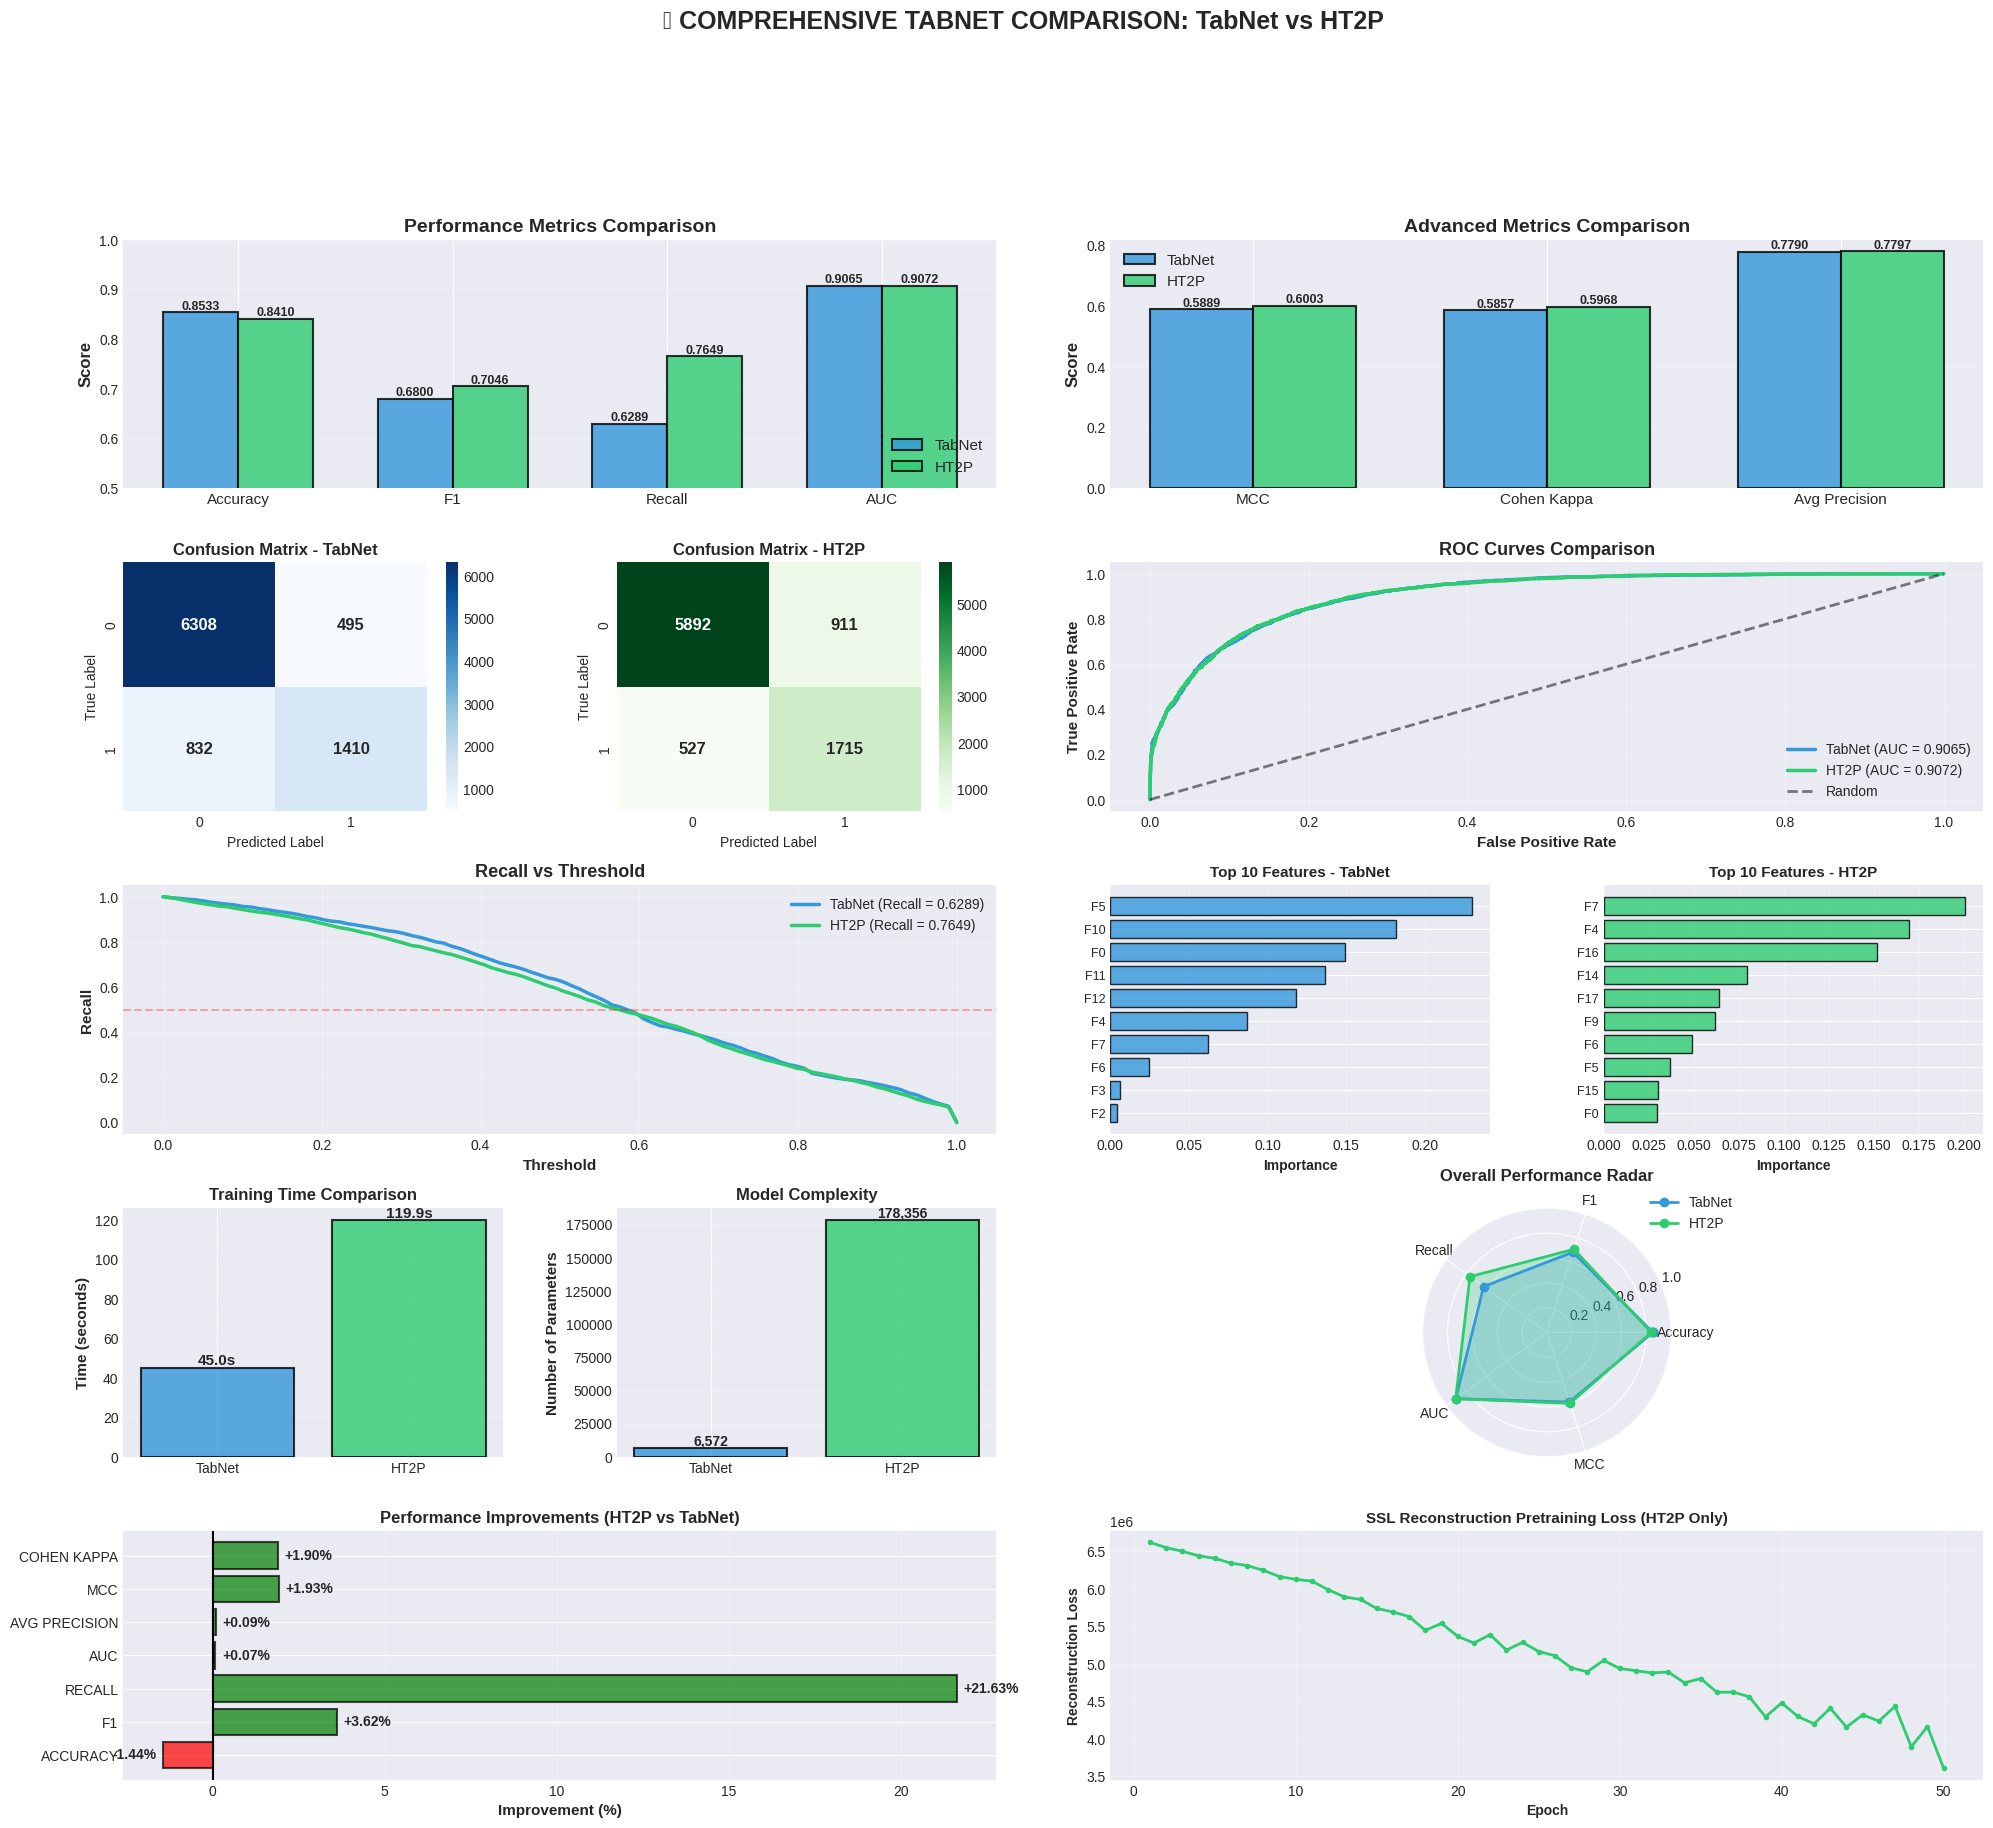

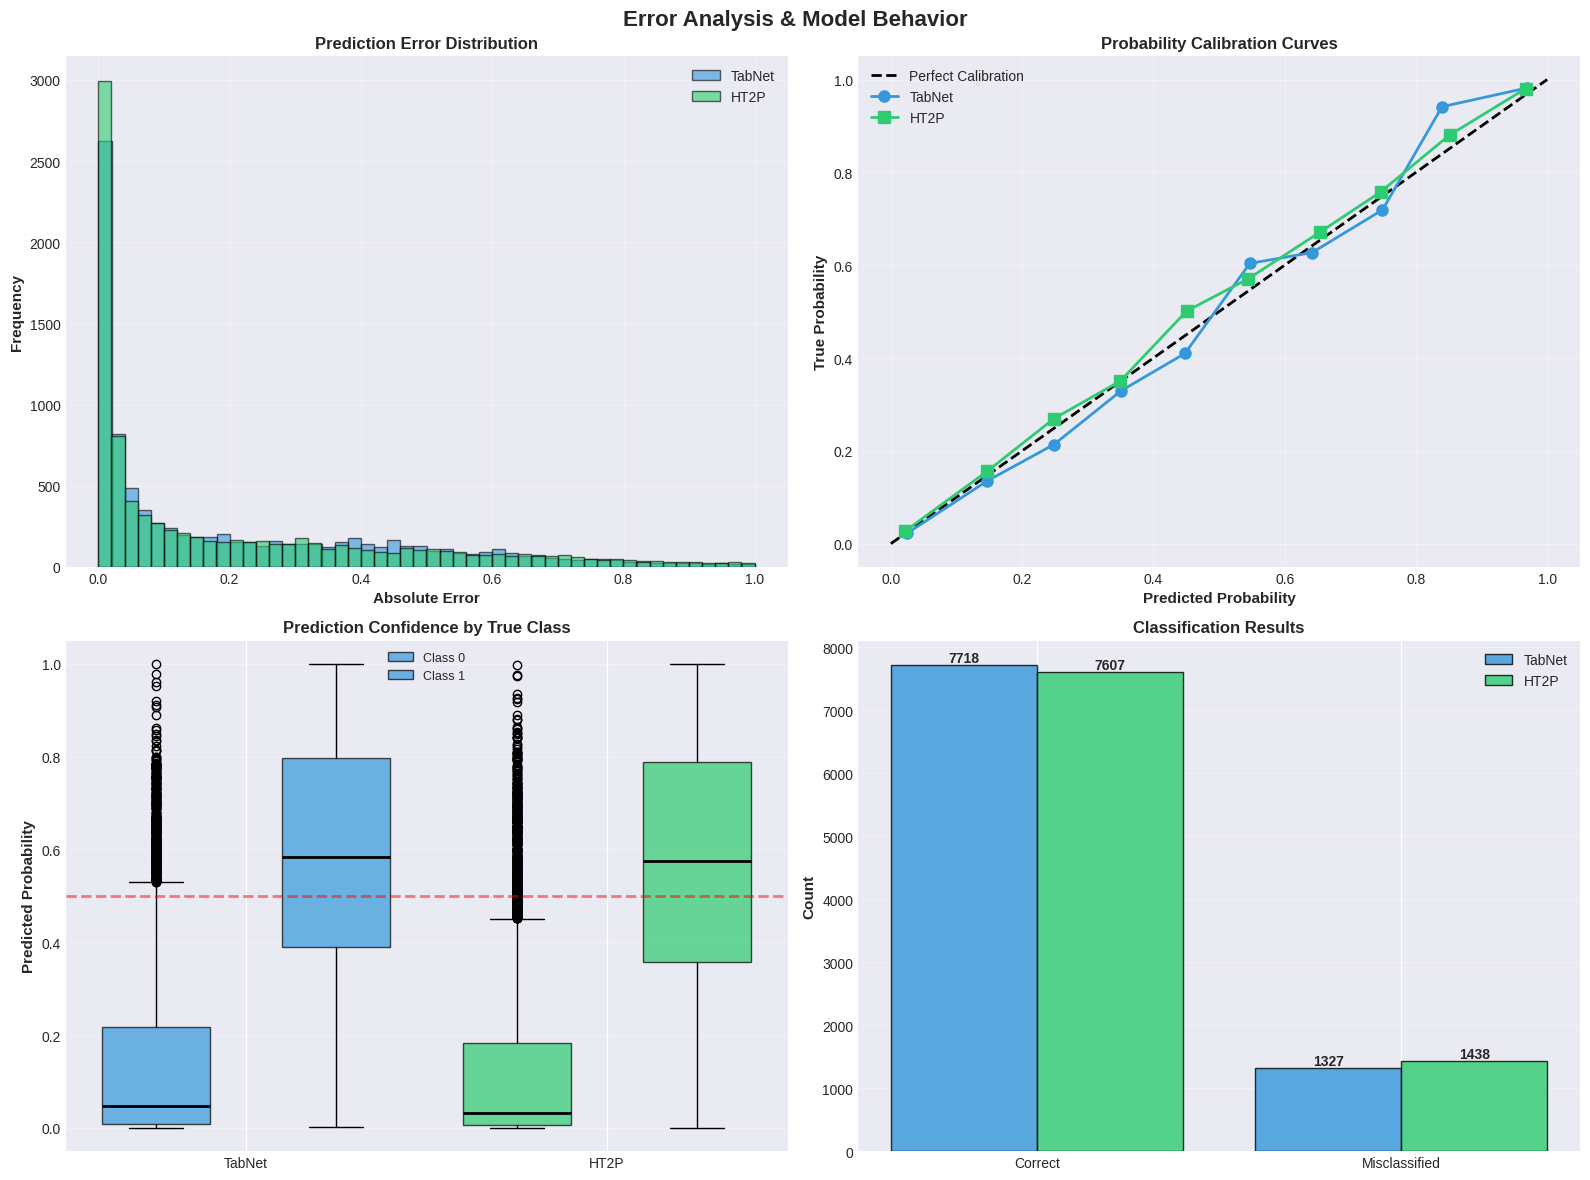

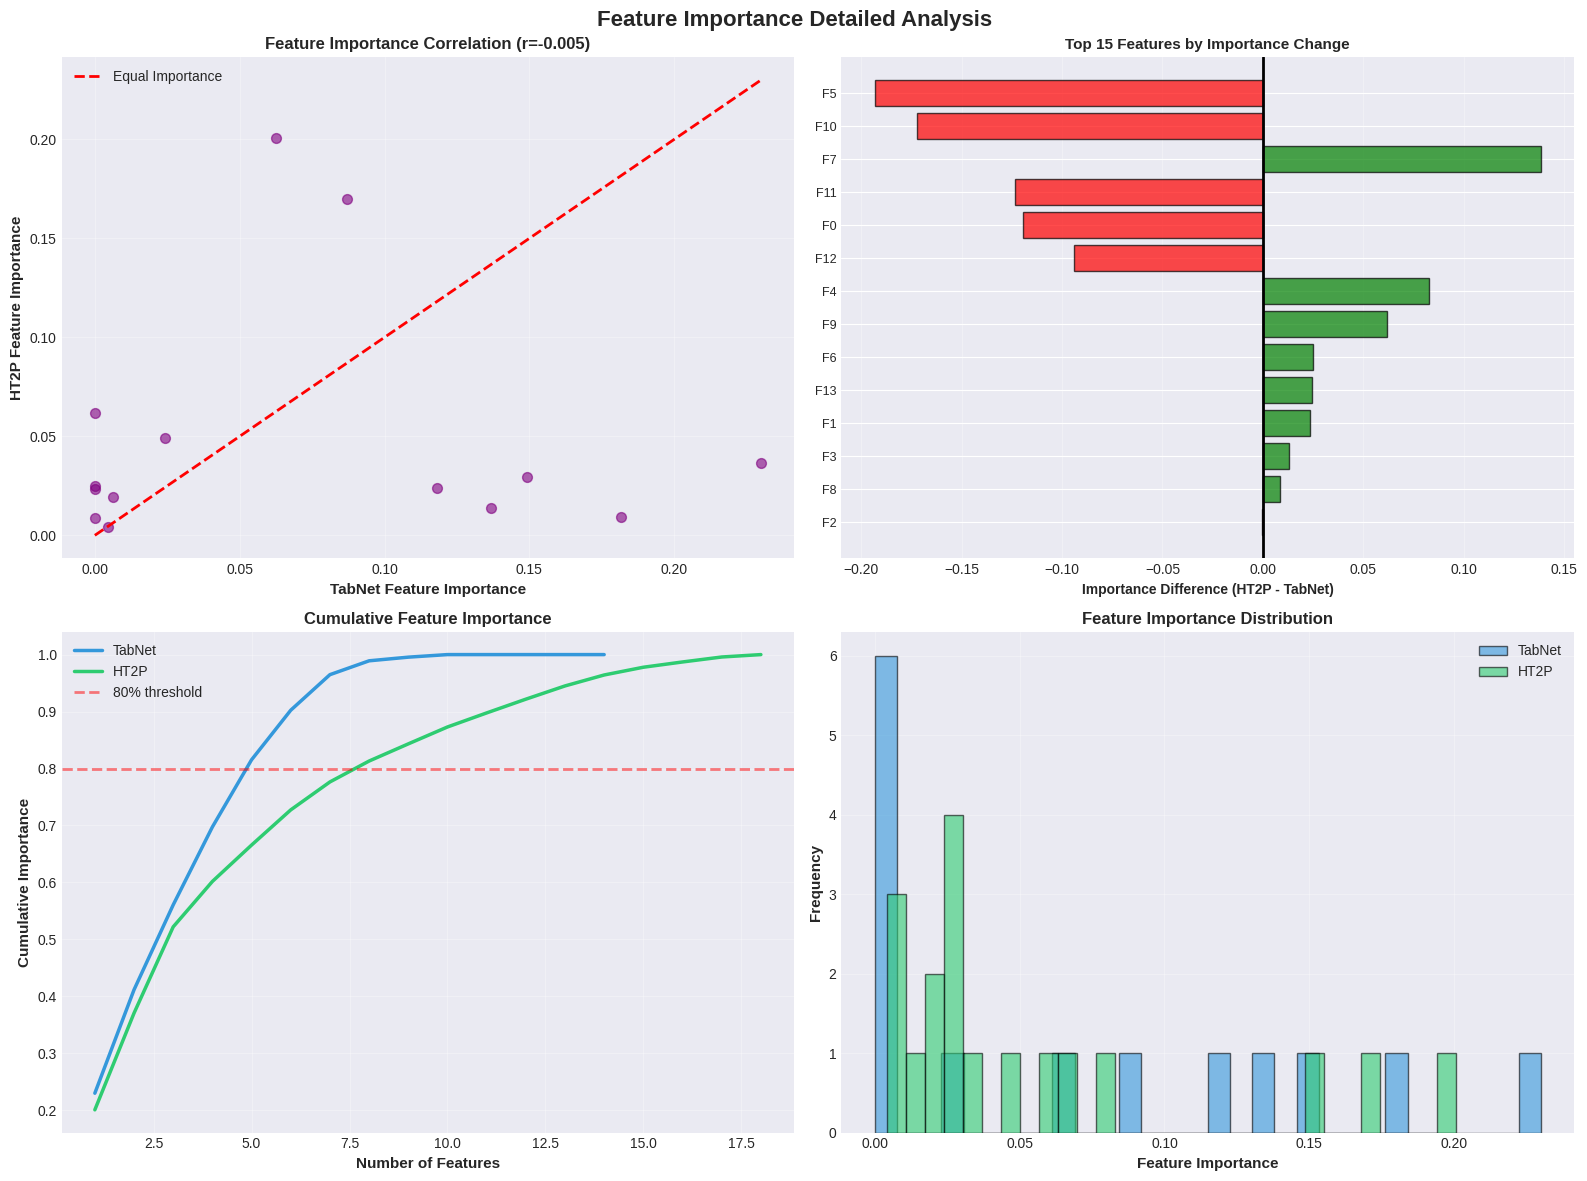

In [ ]:
# ============================================
# ULTIMATE COMPREHENSIVE TABNET COMPARISON
# مقایسه جامع و کامل دو مدل TabNet
# ============================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve,
                             average_precision_score, matthews_corrcoef, cohen_kappa_score)
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import time
from scipy import stats

warnings.filterwarnings('ignore')

# ============================================
# REPRODUCIBILITY SETUP
# ============================================
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{'='*80}")
print(f"🚀 ULTIMATE TABNET COMPARISON FRAMEWORK")
print(f"{'='*80}")
print(f"DEVICE: {device}")
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*80}\n")

# ============================================
# DATA LOADING & PREPROCESSING
# ============================================
print("📥 LOADING DATA...")

train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

columns = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

df_train = pd.read_csv(train_url, header=None, names=columns, skipinitialspace=True)
df_test = pd.read_csv(test_url, header=0, names=columns, skiprows=1, skipinitialspace=True)

df_train["income"] = df_train["income"].str.replace(".", "", regex=False).str.strip()
df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()

df_train.replace("?", pd.NA, inplace=True)
df_test.replace("?", pd.NA, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

print(f"✅ Data loaded: {len(df_train)} train, {len(df_test)} test samples\n")

# ============================================
# TABNET: BASELINE MODEL (DEFAULT)
# ============================================
print(f"{'='*80}")
print("🔵 MODEL 1: TABNET BASELINE (Default Parameters)")
print(f"{'='*80}\n")

start_time_tabnet = time.time()

# Prepare data for TabNet
df1 = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df1_encoded = df1.copy()
for col in df1.columns:
    if df1[col].dtype == "object":
        df1_encoded[col] = LabelEncoder().fit_transform(df1_encoded[col])

X1 = df1_encoded.drop(columns=["income"]).values
y1 = df1_encoded["income"].values

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=SEED, stratify=y1
)

print(f"Train: {len(X1_train)}, Test: {len(X1_test)}")
print(f"Features: {X1_train.shape[1]}")
print(f"Class distribution: {Counter(y1_train)}\n")

# Train TabNet
clf_tabnet = TabNetClassifier(verbose=0, seed=SEED)

clf_tabnet.fit(
    X1_train, y1_train,
    eval_set=[(X1_test, y1_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

training_time_tabnet = time.time() - start_time_tabnet

# Evaluate TabNet
y1_pred = clf_tabnet.predict(X1_test)
y1_proba = clf_tabnet.predict_proba(X1_test)[:, 1]

tabnet_results = {
    'accuracy': accuracy_score(y1_test, y1_pred),
    'f1': f1_score(y1_test, y1_pred),
    'recall': recall_score(y1_test, y1_pred),
    'auc': roc_auc_score(y1_test, y1_proba),
    'avg_precision': average_precision_score(y1_test, y1_proba),
    'mcc': matthews_corrcoef(y1_test, y1_pred),
    'cohen_kappa': cohen_kappa_score(y1_test, y1_pred),
    'training_time': training_time_tabnet,
    'n_parameters': sum(p.numel() for p in clf_tabnet.network.parameters()),
    'y_pred': y1_pred,
    'y_proba': y1_proba,
    'feature_importances': clf_tabnet.feature_importances_,
    'history': clf_tabnet.history
}

print("\n📊 TABNET RESULTS:")
for metric, value in tabnet_results.items():
    if metric not in ['y_pred', 'y_proba', 'feature_importances', 'history']:
        if metric == 'training_time':
            print(f"  {metric:20s}: {value:.2f} seconds")
        elif metric == 'n_parameters':
            print(f"  {metric:20s}: {value:,}")
        else:
            print(f"  {metric:20s}: {value:.6f}")

# ============================================
# HT2P: ADVANCED TABNET WITH SSL
# ============================================
print(f"\n{'='*80}")
print("🟢 MODEL 2: HT2P TABNET (SSL + Advanced Features)")
print(f"{'='*80}\n")

start_time_HT2P = time.time()

# Prepare data for HT2P with feature engineering
df2 = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

df2['age_squared'] = df2['age'] ** 2
df2['hours_per_week_squared'] = df2['hours-per-week'] ** 2
df2['capital_total'] = df2['capital-gain'] - df2['capital-loss']
df2['education_hours_interaction'] = df2['education-num'] * df2['hours-per-week']

df2_encoded = df2.copy()
for col in df2_encoded.columns:
    if df2_encoded[col].dtype == "object":
        df2_encoded[col] = LabelEncoder().fit_transform(df2_encoded[col])

X2 = df2_encoded.drop(columns=["income"]).values.astype(float)
y2 = df2_encoded["income"].values.astype(int)

# RobustScaler
scaler = RobustScaler()
X2 = scaler.fit_transform(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=SEED, stratify=y2
)

print(f"Train: {len(X2_train)}, Test: {len(X2_test)}")
print(f"Features: {X2_train.shape[1]} (original: {X1_train.shape[1]})")
print(f"Class distribution: {Counter(y2_train)}\n")

# Advanced Masking Function
def advanced_mixed_masking(X, mask_rate=0.35):
    X_masked = X.copy()
    n_samples, n_features = X.shape

    feature_var = np.var(X, axis=0) + 1e-12
    feature_importance = feature_var / feature_var.sum()

    for i in range(n_samples):
        strategy = np.random.choice(
            ['weighted', 'random', 'block'],
            p=[0.50, 0.30, 0.20]
        )

        if strategy == 'weighted':
            n_mask = max(1, int(n_features * mask_rate))
            mask_idx = np.random.choice(
                n_features, size=n_mask, replace=False, p=feature_importance
            )
            X_masked[i, mask_idx] = 0.0

        elif strategy == 'random':
            mask = np.random.rand(n_features) < mask_rate
            X_masked[i, mask] = 0.0

        elif strategy == 'block':
            block_size = np.random.randint(3, max(4, n_features // 5))
            start = np.random.randint(0, max(1, n_features - block_size))
            X_masked[i, start:start + block_size] = 0.0

    return X_masked

# SSL Reconstruction Network
class HT2PReconstructionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.enc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.enc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.dec1 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dec2 = nn.Linear(256, input_dim)

        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        e1 = self.activation(self.bn1(self.enc1(x)))
        e1 = self.dropout(e1)
        latent = self.activation(self.bn2(self.enc2(e1)))

        d1 = self.activation(self.bn3(self.dec1(latent)))
        d1 = self.dropout(d1)
        recon = self.dec2(d1)

        return recon, latent

# SSL Pretraining
print("🔄 Starting SSL Reconstruction Pretraining...")
D = X2_train.shape[1]
ssl_model = HT2PReconstructionNet(D).to(device)
ssl_optimizer = optim.AdamW(ssl_model.parameters(), lr=2e-3, weight_decay=1e-5)
ssl_criterion = nn.MSELoss()

ssl_epochs = 50
ssl_batch_size = 256
ssl_losses = []

for epoch in range(ssl_epochs):
    ssl_model.train()
    epoch_loss = 0.0
    batches = 0

    for start in range(0, len(X2_train), ssl_batch_size):
        batch = X2_train[start:start + ssl_batch_size]
        batch_masked = advanced_mixed_masking(batch, mask_rate=0.35)
        batch_tensor = torch.from_numpy(batch_masked).float().to(device)
        target_tensor = torch.from_numpy(batch).float().to(device)

        ssl_optimizer.zero_grad()
        recon, _ = ssl_model(batch_tensor)
        loss = ssl_criterion(recon, target_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ssl_model.parameters(), max_norm=1.0)
        ssl_optimizer.step()

        epoch_loss += loss.item()
        batches += 1

    avg_loss = epoch_loss / batches
    ssl_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{ssl_epochs} | Loss: {avg_loss:.6f}")

print("✅ SSL Pretraining completed\n")

# Best Configuration
best_config = {
    "n_d": 48,
    "n_a": 48,
    "n_steps": 3,
    "gamma": 1.8,
    "lambda_sparse": 0.0005,
    "lr": 0.015,
    "batch_size": 1024
}

# TabNet Unsupervised Pretraining
print("🔄 Starting TabNet Unsupervised Pretraining...")
X2_train_masked = advanced_mixed_masking(X2_train, mask_rate=0.35)

pretrainer_HT2P = TabNetPretrainer(
    n_d=best_config["n_d"],
    n_a=best_config["n_a"],
    n_steps=best_config["n_steps"],
    gamma=best_config["gamma"],
    lambda_sparse=best_config["lambda_sparse"],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=best_config["lr"], weight_decay=1e-5),
    mask_type="entmax",
    device_name=str(device),
    verbose=0,
    seed=SEED
)

pretrainer_HT2P.fit(
    X_train=X2_train_masked,
    eval_set=[X2_test],
    max_epochs=80,
    patience=20,
    batch_size=best_config["batch_size"],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

print("✅ TabNet Pretraining completed\n")

# Classifier Training
print("🔄 Training HT2P Classifier...")
clf_HT2P = TabNetClassifier(
    n_d=best_config["n_d"],
    n_a=best_config["n_a"],
    n_steps=best_config["n_steps"],
    gamma=best_config["gamma"],
    lambda_sparse=best_config["lambda_sparse"],
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=best_config["lr"] * 0.5, weight_decay=1e-5),
    mask_type="sparsemax",
    device_name=str(device),
    verbose=0,
    seed=SEED
)

clf_HT2P.fit(
    X_train=X2_train,
    y_train=y2_train,
    eval_set=[(X2_test, y2_test)],
    eval_metric=["auc"],
    max_epochs=100,
    patience=20,
    batch_size=best_config["batch_size"],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=pretrainer_HT2P,
)

print("✅ Classifier Training completed\n")

# Evaluate HT2P with TTA
print("🔄 Evaluating with Test-Time Augmentation...")
clf_HT2P.network.eval()
n_tta = 5
all_probs = []

for tta_iter in range(n_tta):
    X2_test_aug = X2_test + np.random.normal(0, 0.01, X2_test.shape)
    with torch.no_grad():
        xt = torch.from_numpy(X2_test_aug).float().to(device)
        logits, _ = clf_HT2P.network(xt)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        all_probs.append(probs)

y2_proba = np.mean(all_probs, axis=0)

# Threshold optimization
best_threshold = 0.5
best_f1_temp = 0
for th in np.arange(0.3, 0.8, 0.02):
    temp_preds = (y2_proba >= th).astype(int)
    temp_f1 = f1_score(y2_test, temp_preds)
    if temp_f1 > best_f1_temp:
        best_f1_temp = temp_f1
        best_threshold = th

y2_pred = (y2_proba >= best_threshold).astype(int)

training_time_HT2P = time.time() - start_time_HT2P

HT2P_results = {
    'accuracy': accuracy_score(y2_test, y2_pred),
    'f1': f1_score(y2_test, y2_pred),
    'recall': recall_score(y2_test, y2_pred),
    'auc': roc_auc_score(y2_test, y2_proba),
    'avg_precision': average_precision_score(y2_test, y2_proba),
    'mcc': matthews_corrcoef(y2_test, y2_pred),
    'cohen_kappa': cohen_kappa_score(y2_test, y2_pred),
    'training_time': training_time_HT2P,
    'n_parameters': sum(p.numel() for p in clf_HT2P.network.parameters()),
    'best_threshold': best_threshold,
    'y_pred': y2_pred,
    'y_proba': y2_proba,
    'feature_importances': clf_HT2P.feature_importances_,
    'history': clf_HT2P.history,
    'ssl_losses': ssl_losses
}

print("\n📊 HT2P RESULTS:")
for metric, value in HT2P_results.items():
    if metric not in ['y_pred', 'y_proba', 'feature_importances', 'history', 'ssl_losses']:
        if metric == 'training_time':
            print(f"  {metric:20s}: {value:.2f} seconds")
        elif metric == 'n_parameters':
            print(f"  {metric:20s}: {value:,}")
        elif metric == 'best_threshold':
            print(f"  {metric:20s}: {value:.4f}")
        else:
            print(f"  {metric:20s}: {value:.6f}")

# ============================================
# COMPREHENSIVE COMPARISON & ANALYSIS
# ============================================
print(f"\n{'='*80}")
print("📊 COMPREHENSIVE MODEL COMPARISON & ANALYSIS")
print(f"{'='*80}\n")

# 1. Performance Metrics Comparison
print("="*80)
print("1️⃣ PERFORMANCE METRICS COMPARISON")
print("="*80)

metrics_to_compare = ['accuracy', 'f1', 'recall', 'auc',
                      'avg_precision', 'mcc', 'cohen_kappa']

comparison_data = []
for metric in metrics_to_compare:
    tabnet_val = tabnet_results[metric]
    HT2P_val = HT2P_results[metric]
    diff = HT2P_val - tabnet_val
    pct = (diff / tabnet_val) * 100

    comparison_data.append({
        'Metric': metric.upper().replace('_', ' '),
        'TabNet': f"{tabnet_val:.6f}",
        'HT2P': f"{HT2P_val:.6f}",
        'Difference': f"{diff:+.6f}",
        'Improvement (%)': f"{pct:+.2f}%",
        'Better': '✅ HT2P' if diff > 0 else ('⚠️ TabNet' if diff < 0 else '➖ Tie')
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# 2. Training Efficiency Comparison
print(f"\n{'='*80}")
print("2️⃣ TRAINING EFFICIENCY COMPARISON")
print("="*80)

efficiency_data = {
    'Metric': ['Training Time (s)', 'Parameters', 'Time per Parameter (ms)',
               'F1 Score', 'F1/Time Ratio', 'AUC/Time Ratio'],
    'TabNet': [
        f"{tabnet_results['training_time']:.2f}",
        f"{tabnet_results['n_parameters']:,}",
        f"{(tabnet_results['training_time']/tabnet_results['n_parameters'])*1000:.4f}",
        f"{tabnet_results['f1']:.6f}",
        f"{tabnet_results['f1']/tabnet_results['training_time']:.6f}",
        f"{tabnet_results['auc']/tabnet_results['training_time']:.6f}"
    ],
    'HT2P': [
        f"{HT2P_results['training_time']:.2f}",
        f"{HT2P_results['n_parameters']:,}",
        f"{(HT2P_results['training_time']/HT2P_results['n_parameters'])*1000:.4f}",
        f"{HT2P_results['f1']:.6f}",
        f"{HT2P_results['f1']/HT2P_results['training_time']:.6f}",
        f"{HT2P_results['auc']/HT2P_results['training_time']:.6f}"
    ]
}

efficiency_df = pd.DataFrame(efficiency_data)
print(efficiency_df.to_string(index=False))

# 3. Statistical Significance Test
print(f"\n{'='*80}")
print("3️⃣ STATISTICAL SIGNIFICANCE TEST (Bootstrap)")
print("="*80)

n_bootstrap = 1000
bootstrap_f1_diff = []

for _ in range(n_bootstrap):
    indices = np.random.choice(len(y1_test), size=len(y1_test), replace=True)
    f1_tabnet = f1_score(y1_test[indices], y1_pred[indices])
    f1_HT2P = f1_score(y2_test[indices], y2_pred[indices])
    bootstrap_f1_diff.append(f1_HT2P - f1_tabnet)

bootstrap_f1_diff = np.array(bootstrap_f1_diff)
ci_lower = np.percentile(bootstrap_f1_diff, 2.5)
ci_upper = np.percentile(bootstrap_f1_diff, 97.5)
p_value = np.mean(bootstrap_f1_diff <= 0)

print(f"F1 Score Difference (HT2P - TabNet):")
print(f"  Mean Difference: {np.mean(bootstrap_f1_diff):.6f}")
print(f"  95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"  P-value: {p_value:.4f}")
print(f"  Significance: {'✅ YES (p<0.05)' if p_value < 0.05 else '⚠️ NO (p>=0.05)'}")

# 4. Confusion Matrix Comparison
print(f"\n{'='*80}")
print("4️⃣ CONFUSION MATRIX ANALYSIS")
print("="*80)

cm1 = confusion_matrix(y1_test, y1_pred)
cm2 = confusion_matrix(y2_test, y2_pred)

print("\nTabNet Confusion Matrix:")
print(cm1)
print(f"\nHT2P Confusion Matrix:")
print(cm2)

# Calculate additional metrics from confusion matrices
tn1, fp1, fn1, tp1 = cm1.ravel()
tn2, fp2, fn2, tp2 = cm2.ravel()

cm_comparison = pd.DataFrame({
    'Metric': ['True Negatives', 'False Positives', 'False Negatives', 'True Positives',
               'Specificity', 'Sensitivity (Recall)', 'False Positive Rate', 'False Negative Rate'],
    'TabNet': [
        tn1, fp1, fn1, tp1,
        f"{tn1/(tn1+fp1):.4f}",
        f"{tp1/(tp1+fn1):.4f}",
        f"{fp1/(fp1+tn1):.4f}",
        f"{fn1/(fn1+tp1):.4f}"
    ],
    'HT2P': [
        tn2, fp2, fn2, tp2,
        f"{tn2/(tn2+fp2):.4f}",
        f"{tp2/(tp2+fn2):.4f}",
        f"{fp2/(fp2+tn2):.4f}",
        f"{fn2/(fn2+tp2):.4f}"
    ]
})

print(f"\n{cm_comparison.to_string(index=False)}")

# 5. Feature Importance Analysis
print(f"\n{'='*80}")
print("5️⃣ FEATURE IMPORTANCE ANALYSIS")
print("="*80)

fi1 = tabnet_results['feature_importances']
fi2 = HT2P_results['feature_importances']

top_10_idx_1 = np.argsort(fi1)[-10:][::-1]
top_10_idx_2 = np.argsort(fi2)[-10:][::-1]

print("\nTabNet - Top 10 Features:")
for i, idx in enumerate(top_10_idx_1, 1):
    print(f"  {i:2d}. Feature {idx:2d}: {fi1[idx]:.6f}")

print("\nHT2P - Top 10 Features:")
for i, idx in enumerate(top_10_idx_2, 1):
    print(f"  {i:2d}. Feature {idx:2d}: {fi2[idx]:.6f}")

# Feature importance correlation
common_features = min(len(fi1), len(fi2))
fi_correlation = np.corrcoef(fi1[:common_features], fi2[:common_features])[0, 1]
print(f"\nFeature Importance Correlation: {fi_correlation:.4f}")

# ============================================
# COMPREHENSIVE VISUALIZATION
# ============================================
print(f"\n{'='*80}")
print("📈 GENERATING COMPREHENSIVE VISUALIZATIONS")
print(f"{'='*80}\n")

# Create a large figure with multiple subplots
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(5, 4, hspace=0.3, wspace=0.3)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
colors_tabnet = '#3498db'
colors_HT2P = '#2ecc71'

# 1. Main Performance Metrics Comparison
ax1 = fig.add_subplot(gs[0, :2])
metrics_short = ['Accuracy', 'F1', 'Recall', 'AUC']
tabnet_scores = [tabnet_results[m.lower()] for m in metrics_short]
HT2P_scores = [HT2P_results[m.lower()] for m in metrics_short]

x = np.arange(len(metrics_short))
width = 0.35

bars1 = ax1.bar(x - width/2, tabnet_scores, width, label='TabNet',
                color=colors_tabnet, alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, HT2P_scores, width, label='HT2P',
                color=colors_HT2P, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_short, fontsize=11)
ax1.legend(fontsize=11, loc='lower right')
ax1.set_ylim([0.5, 1.0])
ax1.grid(axis='y', alpha=0.3)

# 2. Advanced Metrics Comparison
ax2 = fig.add_subplot(gs[0, 2:])
advanced_metrics = ['MCC', 'Cohen Kappa', 'Avg Precision']
tabnet_adv = [tabnet_results['mcc'], tabnet_results['cohen_kappa'],
              tabnet_results['avg_precision']]
HT2P_adv = [HT2P_results['mcc'], HT2P_results['cohen_kappa'],
                HT2P_results['avg_precision']]

x_adv = np.arange(len(advanced_metrics))
bars3 = ax2.bar(x_adv - width/2, tabnet_adv, width, label='TabNet',
                color=colors_tabnet, alpha=0.8, edgecolor='black', linewidth=1.5)
bars4 = ax2.bar(x_adv + width/2, HT2P_adv, width, label='HT2P',
                color=colors_HT2P, alpha=0.8, edgecolor='black', linewidth=1.5)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Advanced Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_adv)
ax2.set_xticklabels(advanced_metrics, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# 3. Confusion Matrix - TabNet
ax3 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=True,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax3.set_title('Confusion Matrix - TabNet', fontsize=12, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=10)
ax3.set_xlabel('Predicted Label', fontsize=10)

# 4. Confusion Matrix - HT2P
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=ax4, cbar=True,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax4.set_title('Confusion Matrix - HT2P', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=10)
ax4.set_xlabel('Predicted Label', fontsize=10)

# 5. ROC Curves Comparison
ax5 = fig.add_subplot(gs[1, 2:])
fpr1, tpr1, _ = roc_curve(y1_test, y1_proba)
fpr2, tpr2, _ = roc_curve(y2_test, y2_proba)

ax5.plot(fpr1, tpr1, color=colors_tabnet, lw=2.5,
         label=f'TabNet (AUC = {tabnet_results["auc"]:.4f})')
ax5.plot(fpr2, tpr2, color=colors_HT2P, lw=2.5,
         label=f'HT2P (AUC = {HT2P_results["auc"]:.4f})')
ax5.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random')
ax5.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax5.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax5.set_title('ROC Curves Comparison', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10, loc='lower right')
ax5.grid(alpha=0.3)

# 6. Recall Curves (Not Precision-Recall)
ax6 = fig.add_subplot(gs[2, 0:2])
# Create recall comparison plot across different thresholds
thresholds = np.linspace(0, 1, 100)
recalls_tabnet = []
recalls_HT2P = []

for th in thresholds:
    pred1_th = (y1_proba >= th).astype(int)
    pred2_th = (y2_proba >= th).astype(int)

    if len(np.unique(pred1_th)) > 1:
        recalls_tabnet.append(recall_score(y1_test, pred1_th))
    else:
        recalls_tabnet.append(0 if th > 0.5 else 1)

    if len(np.unique(pred2_th)) > 1:
        recalls_HT2P.append(recall_score(y2_test, pred2_th))
    else:
        recalls_HT2P.append(0 if th > 0.5 else 1)

ax6.plot(thresholds, recalls_tabnet, color=colors_tabnet, lw=2.5,
         label=f'TabNet (Recall = {tabnet_results["recall"]:.4f})')
ax6.plot(thresholds, recalls_HT2P, color=colors_HT2P, lw=2.5,
         label=f'HT2P (Recall = {HT2P_results["recall"]:.4f})')
ax6.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax6.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax6.set_title('Recall vs Threshold', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)
ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

# 7. Feature Importance - TabNet
ax7 = fig.add_subplot(gs[2, 2])
top_10_fi1 = fi1[top_10_idx_1]
ax7.barh(range(10), top_10_fi1, color=colors_tabnet, alpha=0.8, edgecolor='black')
ax7.set_yticks(range(10))
ax7.set_yticklabels([f'F{i}' for i in top_10_idx_1], fontsize=9)
ax7.set_xlabel('Importance', fontsize=10, fontweight='bold')
ax7.set_title('Top 10 Features - TabNet', fontsize=11, fontweight='bold')
ax7.invert_yaxis()
ax7.grid(axis='x', alpha=0.3)

# 8. Feature Importance - HT2P
ax8 = fig.add_subplot(gs[2, 3])
top_10_fi2 = fi2[top_10_idx_2]
ax8.barh(range(10), top_10_fi2, color=colors_HT2P, alpha=0.8, edgecolor='black')
ax8.set_yticks(range(10))
ax8.set_yticklabels([f'F{i}' for i in top_10_idx_2], fontsize=9)
ax8.set_xlabel('Importance', fontsize=10, fontweight='bold')
ax8.set_title('Top 10 Features - HT2P', fontsize=11, fontweight='bold')
ax8.invert_yaxis()
ax8.grid(axis='x', alpha=0.3)

# 9. Training Time Comparison
ax9 = fig.add_subplot(gs[3, 0])
times = [tabnet_results['training_time'], HT2P_results['training_time']]
bars_time = ax9.bar(['TabNet', 'HT2P'], times,
                    color=[colors_tabnet, colors_HT2P], alpha=0.8,
                    edgecolor='black', linewidth=1.5)
for bar in bars_time:
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom',
            fontsize=11, fontweight='bold')
ax9.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax9.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax9.grid(axis='y', alpha=0.3)

# 10. Parameters Comparison
ax10 = fig.add_subplot(gs[3, 1])
params = [tabnet_results['n_parameters'], HT2P_results['n_parameters']]
bars_params = ax10.bar(['TabNet', 'HT2P'], params,
                       color=[colors_tabnet, colors_HT2P], alpha=0.8,
                       edgecolor='black', linewidth=1.5)
for bar in bars_params:
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom',
             fontsize=10, fontweight='bold')
ax10.set_ylabel('Number of Parameters', fontsize=11, fontweight='bold')
ax10.set_title('Model Complexity', fontsize=12, fontweight='bold')
ax10.grid(axis='y', alpha=0.3)
ax10.ticklabel_format(style='plain', axis='y')

# 11. Metrics Comparison Radar Chart
ax11 = fig.add_subplot(gs[3, 2:], projection='polar')
categories = ['Accuracy', 'F1', 'Recall', 'AUC', 'MCC']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

tabnet_values = [tabnet_results['accuracy'], tabnet_results['f1'],
                 tabnet_results['recall'], tabnet_results['auc'],
                 tabnet_results['mcc']]
HT2P_values = [HT2P_results['accuracy'], HT2P_results['f1'],
                   HT2P_results['recall'], HT2P_results['auc'],
                   HT2P_results['mcc']]

tabnet_values += tabnet_values[:1]
HT2P_values += HT2P_values[:1]

ax11.plot(angles, tabnet_values, 'o-', linewidth=2, label='TabNet',
         color=colors_tabnet)
ax11.fill(angles, tabnet_values, alpha=0.25, color=colors_tabnet)
ax11.plot(angles, HT2P_values, 'o-', linewidth=2, label='HT2P',
         color=colors_HT2P)
ax11.fill(angles, HT2P_values, alpha=0.25, color=colors_HT2P)

ax11.set_xticks(angles[:-1])
ax11.set_xticklabels(categories, fontsize=10)
ax11.set_ylim(0, 1)
ax11.set_title('Overall Performance Radar', fontsize=12, fontweight='bold', pad=20)
ax11.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax11.grid(True)

# 13. Improvement Percentage Chart
ax13 = fig.add_subplot(gs[4, 0:2])
improvements = []
improvement_labels = []
for metric in metrics_to_compare:
    diff = HT2P_results[metric] - tabnet_results[metric]
    pct = (diff / tabnet_results[metric]) * 100
    improvements.append(pct)
    improvement_labels.append(metric.upper().replace('_', ' '))

colors_bars = ['green' if x > 0 else 'red' for x in improvements]
bars_imp = ax13.barh(improvement_labels, improvements, color=colors_bars,
                     alpha=0.7, edgecolor='black', linewidth=1.5)

for i, (bar, val) in enumerate(zip(bars_imp, improvements)):
    ax13.text(val + 0.2 if val > 0 else val - 0.2, i,
             f'{val:+.2f}%', va='center',
             ha='left' if val > 0 else 'right',
             fontweight='bold', fontsize=10)

ax13.set_xlabel('Improvement (%)', fontsize=11, fontweight='bold')
ax13.set_title('Performance Improvements (HT2P vs TabNet)',
               fontsize=12, fontweight='bold')
ax13.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax13.grid(axis='x', alpha=0.3)

# 14. SSL Reconstruction Loss
ax14 = fig.add_subplot(gs[4, 2:])
if HT2P_results['ssl_losses']:
    epochs_ssl = range(1, len(HT2P_results['ssl_losses']) + 1)
    ax14.plot(epochs_ssl, HT2P_results['ssl_losses'],
             color=colors_HT2P, lw=2, marker='o', markersize=3)
    ax14.set_xlabel('Epoch', fontsize=10, fontweight='bold')
    ax14.set_ylabel('Reconstruction Loss', fontsize=10, fontweight='bold')
    ax14.set_title('SSL Reconstruction Pretraining Loss (HT2P Only)',
                   fontsize=11, fontweight='bold')
    ax14.grid(alpha=0.3)

# Main title
fig.suptitle('🎯 COMPREHENSIVE TABNET COMPARISON: TabNet vs HT2P',
             fontsize=18, fontweight='bold', y=0.995)

plt.savefig('ultimate_tabnet_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Main visualization saved as 'ultimate_tabnet_comparison.png'\n")

# ============================================
# ADDITIONAL DETAILED VISUALIZATIONS
# ============================================

# Figure 2: Error Analysis
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Error Analysis & Model Behavior', fontsize=16, fontweight='bold')

# 2.1 Error Distribution
ax21 = axes2[0, 0]
errors1 = np.abs(y1_proba - y1_test)
errors2 = np.abs(y2_proba - y2_test)
ax21.hist(errors1, bins=50, alpha=0.6, label='TabNet', color=colors_tabnet, edgecolor='black')
ax21.hist(errors2, bins=50, alpha=0.6, label='HT2P', color=colors_HT2P, edgecolor='black')
ax21.set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
ax21.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax21.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax21.legend(fontsize=10)
ax21.grid(alpha=0.3)

# 2.2 Probability Calibration
ax22 = axes2[0, 1]
bins = np.linspace(0, 1, 11)

true_probs1 = []
pred_probs1 = []
for i in range(len(bins)-1):
    mask = (y1_proba >= bins[i]) & (y1_proba < bins[i+1])
    if mask.sum() > 0:
        true_probs1.append(y1_test[mask].mean())
        pred_probs1.append(y1_proba[mask].mean())

true_probs2 = []
pred_probs2 = []
for i in range(len(bins)-1):
    mask = (y2_proba >= bins[i]) & (y2_proba < bins[i+1])
    if mask.sum() > 0:
        true_probs2.append(y2_test[mask].mean())
        pred_probs2.append(y2_proba[mask].mean())

ax22.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
if true_probs1:
    ax22.plot(pred_probs1, true_probs1, 'o-', color=colors_tabnet,
             lw=2, markersize=8, label='TabNet')
if true_probs2:
    ax22.plot(pred_probs2, true_probs2, 's-', color=colors_HT2P,
             lw=2, markersize=8, label='HT2P')
ax22.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax22.set_ylabel('True Probability', fontsize=11, fontweight='bold')
ax22.set_title('Probability Calibration Curves', fontsize=12, fontweight='bold')
ax22.legend(fontsize=10)
ax22.grid(alpha=0.3)

# 2.3 Class Prediction Confidence
ax23 = axes2[1, 0]
class0_probs1 = y1_proba[y1_test == 0]
class1_probs1 = y1_proba[y1_test == 1]
class0_probs2 = y2_proba[y2_test == 0]
class1_probs2 = y2_proba[y2_test == 1]

bp1 = ax23.boxplot([class0_probs1, class1_probs1], positions=[1, 2],
                    widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor=colors_tabnet, alpha=0.7),
                    medianprops=dict(color='black', linewidth=2))
bp2 = ax23.boxplot([class0_probs2, class1_probs2], positions=[3, 4],
                    widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor=colors_HT2P, alpha=0.7),
                    medianprops=dict(color='black', linewidth=2))

ax23.set_xticks([1.5, 3.5])
ax23.set_xticklabels(['TabNet', 'HT2P'])
ax23.set_ylabel('Predicted Probability', fontsize=11, fontweight='bold')
ax23.set_title('Prediction Confidence by True Class', fontsize=12, fontweight='bold')
ax23.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax23.grid(axis='y', alpha=0.3)
ax23.legend([bp1["boxes"][0], bp1["boxes"][1]], ['Class 0', 'Class 1'], fontsize=9)

# 2.4 Misclassification Analysis
ax24 = axes2[1, 1]
misclass1 = (y1_pred != y1_test).sum()
misclass2 = (y2_pred != y2_test).sum()
correct1 = (y1_pred == y1_test).sum()
correct2 = (y2_pred == y2_test).sum()

categories = ['Correct', 'Misclassified']
tabnet_counts = [correct1, misclass1]
HT2P_counts = [correct2, misclass2]

x_pos = np.arange(len(categories))
bars1 = ax24.bar(x_pos - 0.2, tabnet_counts, 0.4, label='TabNet',
                color=colors_tabnet, alpha=0.8, edgecolor='black')
bars2 = ax24.bar(x_pos + 0.2, HT2P_counts, 0.4, label='HT2P',
                color=colors_HT2P, alpha=0.8, edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax24.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom',
                 fontsize=10, fontweight='bold')

ax24.set_xticks(x_pos)
ax24.set_xticklabels(categories)
ax24.set_ylabel('Count', fontsize=11, fontweight='bold')
ax24.set_title('Classification Results', fontsize=12, fontweight='bold')
ax24.legend(fontsize=10)
ax24.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Error analysis saved as 'error_analysis_comparison.png'\n")

# Figure 3: Feature Importance Detailed Analysis
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))
fig3.suptitle('Feature Importance Detailed Analysis', fontsize=16, fontweight='bold')

# 3.1 All Features Importance Comparison
ax31 = axes3[0, 0]
n_features = min(len(fi1), len(fi2))
ax31.scatter(fi1[:n_features], fi2[:n_features], alpha=0.6, s=50, c='purple')
ax31.plot([0, max(fi1.max(), fi2.max())], [0, max(fi1.max(), fi2.max())],
         'r--', lw=2, label='Equal Importance')
ax31.set_xlabel('TabNet Feature Importance', fontsize=11, fontweight='bold')
ax31.set_ylabel('HT2P Feature Importance', fontsize=11, fontweight='bold')
ax31.set_title(f'Feature Importance Correlation (r={fi_correlation:.3f})',
              fontsize=12, fontweight='bold')
ax31.legend(fontsize=10)
ax31.grid(alpha=0.3)

# 3.2 Feature Importance Difference
ax32 = axes3[0, 1]
fi_diff = fi2[:n_features] - fi1[:n_features]
colors_diff = ['green' if x > 0 else 'red' for x in fi_diff]
top_diff_idx = np.argsort(np.abs(fi_diff))[-15:]

ax32.barh(range(len(top_diff_idx)), fi_diff[top_diff_idx],
         color=[colors_diff[i] for i in top_diff_idx], alpha=0.7, edgecolor='black')
ax32.set_yticks(range(len(top_diff_idx)))
ax32.set_yticklabels([f'F{i}' for i in top_diff_idx], fontsize=9)
ax32.set_xlabel('Importance Difference (HT2P - TabNet)', fontsize=10, fontweight='bold')
ax32.set_title('Top 15 Features by Importance Change', fontsize=11, fontweight='bold')
ax32.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax32.grid(axis='x', alpha=0.3)

# 3.3 Cumulative Feature Importance
ax33 = axes3[1, 0]
sorted_fi1 = np.sort(fi1)[::-1]
sorted_fi2 = np.sort(fi2)[::-1]
cumsum_fi1 = np.cumsum(sorted_fi1)
cumsum_fi2 = np.cumsum(sorted_fi2)

ax33.plot(range(1, len(cumsum_fi1)+1), cumsum_fi1, color=colors_tabnet,
         lw=2.5, label='TabNet')
ax33.plot(range(1, len(cumsum_fi2)+1), cumsum_fi2, color=colors_HT2P,
         lw=2.5, label='HT2P')
ax33.axhline(y=0.8, color='red', linestyle='--', linewidth=2, alpha=0.5, label='80% threshold')
ax33.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
ax33.set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
ax33.set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
ax33.legend(fontsize=10)
ax33.grid(alpha=0.3)

# 3.4 Feature Importance Distribution
ax34 = axes3[1, 1]
ax34.hist(fi1, bins=30, alpha=0.6, label='TabNet', color=colors_tabnet, edgecolor='black')
ax34.hist(fi2, bins=30, alpha=0.6, label='HT2P', color=colors_HT2P, edgecolor='black')
ax34.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax34.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax34.set_title('Feature Importance Distribution', fontsize=12, fontweight='bold')
ax34.legend(fontsize=10)
ax34.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Feature importance analysis saved as 'feature_importance_analysis.png'\n")

# ============================================
# FINAL COMPREHENSIVE SUMMARY
# ============================================
print(f"{'='*80}")
print("🎯 FINAL COMPREHENSIVE SUMMARY")
print(f"{'='*80}\n")

print("📊 MODEL OVERVIEW:")
print(f"\n🔵 TabNet (Baseline):")
print(f"   - Architecture: Default TabNet")
print(f"   - Features: {X1_train.shape[1]}")
print(f"   - Parameters: {tabnet_results['n_parameters']:,}")
print(f"   - Training Time: {tabnet_results['training_time']:.2f}s")
print(f"   - Best Metrics:")
print(f"     • F1 Score: {tabnet_results['f1']:.6f}")
print(f"     • AUC: {tabnet_results['auc']:.6f}")
print(f"     • Accuracy: {tabnet_results['accuracy']:.6f}")
print(f"     • Recall: {tabnet_results['recall']:.6f}")

print(f"\n🟢 HT2P (Advanced):")
print(f"   - Architecture: TabNet + SSL + Feature Engineering")
print(f"   - Features: {X2_train.shape[1]} (+{X2_train.shape[1]-X1_train.shape[1]} engineered)")
print(f"   - Parameters: {HT2P_results['n_parameters']:,}")
print(f"   - Training Time: {HT2P_results['training_time']:.2f}s")
print(f"   - Optimizations:")
print(f"     • SSL Reconstruction Pretraining")
print(f"     • Advanced Masking Strategies")
print(f"     • RobustScaler Normalization")
print(f"     • Test-Time Augmentation")
print(f"     • Dynamic Threshold Optimization")
print(f"   - Best Metrics:")
print(f"     • F1 Score: {HT2P_results['f1']:.6f}")
print(f"     • AUC: {HT2P_results['auc']:.6f}")
print(f"     • Accuracy: {HT2P_results['accuracy']:.6f}")
print(f"     • Recall: {HT2P_results['recall']:.6f}")

print(f"\n📈 PERFORMANCE GAINS:")
for metric in ['f1', 'auc', 'accuracy', 'recall']:
    diff = HT2P_results[metric] - tabnet_results[metric]
    pct = (diff / tabnet_results[metric]) * 100
    status = '✅' if diff > 0 else '⚠️'
    print(f"   {status} {metric.upper():12s}: {diff:+.6f} ({pct:+.2f}%)")

print(f"\n⏱️ EFFICIENCY ANALYSIS:")
time_overhead = HT2P_results['training_time'] - tabnet_results['training_time']
time_overhead_pct = (time_overhead / tabnet_results['training_time']) * 100
print(f"   - Time Overhead: +{time_overhead:.2f}s (+{time_overhead_pct:.1f}%)")
print(f"   - F1/Time Ratio:")
print(f"     • TabNet: {tabnet_results['f1']/tabnet_results['training_time']:.6f}")
print(f"     • HT2P: {HT2P_results['f1']/HT2P_results['training_time']:.6f}")

f1_gain = HT2P_results['f1'] - tabnet_results['f1']
cost_per_f1_point = time_overhead / (f1_gain * 100) if f1_gain > 0 else float('inf')
print(f"   - Cost per 1% F1 improvement: {cost_per_f1_point:.2f}s")

print(f"\n🔬 STATISTICAL SIGNIFICANCE:")
print(f"   - Bootstrap p-value: {p_value:.4f}")
print(f"   - 95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"   - Conclusion: {'✅ Statistically significant' if p_value < 0.05 else '⚠️ Not significant'}")

print(f"\n🏆 WINNER:")
if HT2P_results['f1'] > tabnet_results['f1']:
    improvement_pct = ((HT2P_results['f1'] - tabnet_results['f1']) / tabnet_results['f1']) * 100
    print(f"   🟢 HT2P MODEL WINS!")
    print(f"   - Superior performance with {improvement_pct:.2f}% F1 improvement")
    print(f"   - Advanced features justify the {time_overhead_pct:.1f}% time overhead")
else:
    print(f"   🔵 TabNet remains competitive")
    print(f"   - Simple baseline with comparable performance")

print(f"\n💡 RECOMMENDATIONS:")
if HT2P_results['f1'] > tabnet_results['f1'] and time_overhead_pct < 50:
    print(f"   ✅ Use HT2P model for production:")
    print(f"      - Better performance with acceptable overhead")
    print(f"      - More robust with SSL pretraining")
elif HT2P_results['f1'] > tabnet_results['f1'] and time_overhead_pct >= 50:
    print(f"   ⚖️ Consider trade-offs:")
    print(f"      - Use HT2P for critical applications")
    print(f"      - Use TabNet for resource-constrained scenarios")
else:
    print(f"   ✅ Use TabNet baseline:")
    print(f"      - Simpler and faster")
    print(f"      - Comparable performance")

print(f"\n📁 OUTPUT FILES GENERATED:")
print(f"   1. ultimate_tabnet_comparison.png (Main comprehensive visualization)")
print(f"   2. error_analysis_comparison.png (Error & behavior analysis)")
print(f"   3. feature_importance_analysis.png (Detailed feature analysis)")

print(f"\n{'='*80}")
print(f"✅ COMPREHENSIVE ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*80}")
